# IIP - Project 1
### 6252320 - Leon Debnath

Import the required modules for the notebook

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import math

Due to the amount of image plotting required, a helper function was used to abstract the display of images into a single `display()` function that takes a list of images and corresponding labels.

In [8]:
def display(images: list, labels:list[str], axis='off'):
    
    if len(images) != len(labels):
        raise Exception("images and labels don't correspond")
        
    fig = plt.figure(figsize=(15,10))
    cols = 2
    rows = math.ceil(len(images)/2)
    
    for i in range(len(images)):
        fig.add_subplot(rows, cols, i+1)
        plt.imshow(images[i])
        plt.title(labels[i])
        plt.axis(axis)

## Exercise 1 - Colour Spaces

### a. RGB to HSV
Initially the images were loaded using the Open Source Computer Vision library cv2 (in BGR), and were converted to the RGB colour space. 

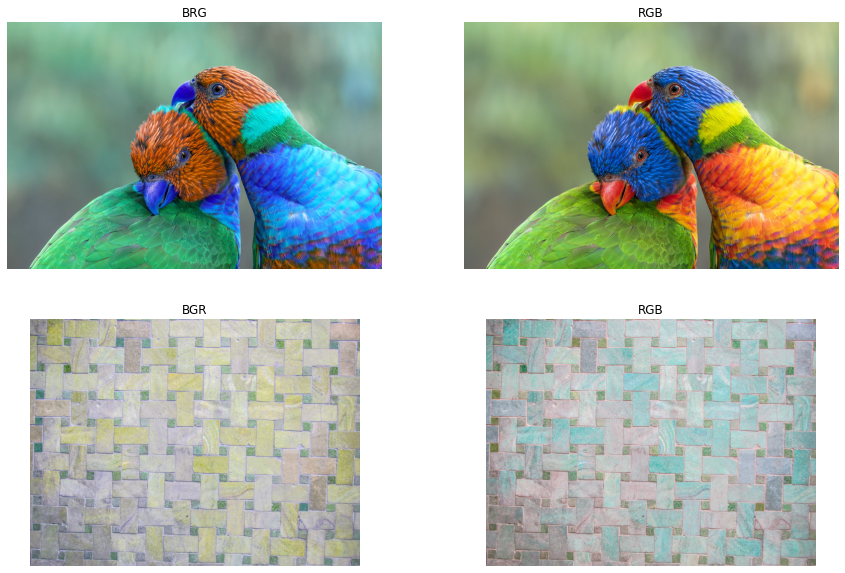

In [9]:
from ex_1 import rgb2hsi, rgb2hsv

img1_bgr = cv2.imread('images/birds.jpg')
img1_rgb = cv2.cvtColor(img1_bgr, cv2.COLOR_BGR2RGB)
img2_bgr = cv2.imread('images/stone.jpg')
img2_rgb = cv2.cvtColor(img2_bgr, cv2.COLOR_BGR2RGB)

display([img1_bgr, img1_rgb, img2_bgr, img2_rgb], ['BRG', 'RGB', 'BGR', 'RGB'])

The **RGB** colour space uses three values in the range $\{0 - 255\}$ for the primary colours; **red**, **green**, and **blue**, which are additively combined into the final colour.  Alternatively **HSV/HSI** use the combination of a **hue** (a $360^{\circ}$ that rotates through all of the visible colours), a level of colour **saturation**, and the **value** or **intensity** respectively

To convert from RGB to HSV, the following set of formulae can be used ([1](https://docs.opencv.org/4.x/de/d25/imgproc_color_conversions.html#color_convert_rgb_hsv)):

**Value:**
$$ 
\begin{equation}
V = max(R, G, B)
\end{equation} 
$$
**Saturation:**
$$
\begin{matrix}
 S_v= & \frac{V - min(R,G,B)}{V} &\text{  if } V \neq 0  \\
  & 0 &\text{otherwise}
\end{matrix}
$$
**Hue:**
$$:
\begin{matrix}
      & \frac{60 \cdot (G - B)}{V - min(R,G,B)} & \text{  if } V = R  \\
 H =  & \frac{120 + 60 \cdot (B - R)}{V - min(R,G,B)} & \text{  if } V = G  \\
      & \frac{240 + 60 \cdot (R - G)}{V - min(R,G,B)} & \text{  if } V = B  \\
      & 0 & \text{ if } R = B = G
\end{matrix}
$$

**N.B.** $S_v$ represents the saturation for HSV colour space 

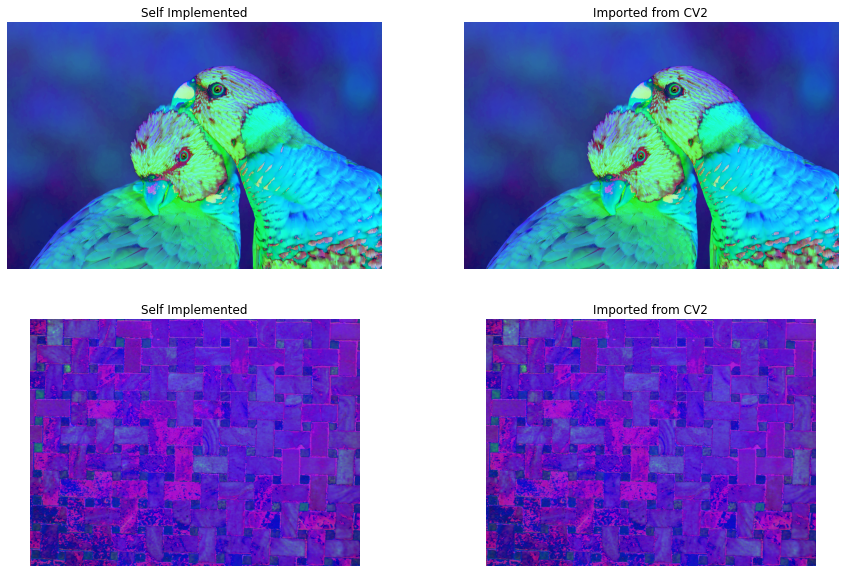

In [13]:
img1_imp_hsv = rgb2hsv(img1_rgb)
img1_cv2_hsv = cv2.cvtColor(img1_rgb, cv2.COLOR_RGB2HSV)
img2_imp_hsv = rgb2hsv(img2_rgb)
img2_cv2_hsv = cv2.cvtColor(img2_rgb, cv2.COLOR_RGB2HSV)

display([img1_imp_hsv, img1_cv2_hsv, img2_imp_hsv, img2_cv2_hsv], 
        ['Self Implemented', 'Imported from CV2', 'Self Implemented', 'Imported from CV2'])

Each of the images rendered in HSV shows clearly the difference in chroma that initially were difficult to distinguish.  This is particularly clear on the second image, a faded stone in pastle blue and pink.  The low intensity of the RGB image makes the colours seem to fade together to the human eye.  In the HSV space, as the chroma and value are encoded on seperate channels, the red areas indicate a clear colour change, while the blue areas of the image show the value (or lightness) of the image. 

Given the lack of almost any green in the second set of images, we can discern that the image is incredibly faded with a very low level of saturation encoded into the green channel of RGB.  The image of the birds, showing vibrant colours in a very high intensity in the foreground displays the greens expected of a highly saturated image.

### b. RGB to HSI

The HSV and HSI models both use the same value for Hue as calculated in the formula above.  The saturation differs as shown below for the HSI model, with intensity replacing value:

**Intensity**

$$
\begin{equation}
    I = \frac{V_{max} + V_{min}}{2}
\end{equation}
$$

**Saturation**

$$
\begin{matrix}
 S_i= & \frac{V_{max} - V_{min}}{V_{max} + V_{min}}       & \text{ if} I \gt 0.5 \\
      & \frac{V_{max} - V_{min}}{2 - (V_{max} + V_{min})} & \text{ if} I \le 0.5   
\end{matrix}
$$

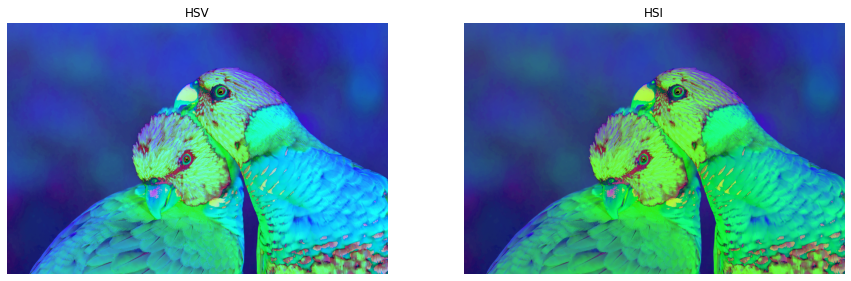

In [18]:
img1_imp_hsi = rgb2hsi(img1_rgb)

display([img1_imp_hsv, img1_imp_hsi], ['HSV', 'HSI'])

Observe that the HSI image more clearly identifies the areas of high saturation in areas of the image. This can be intuitively understood by contrasting the saturation calculations for HSV and HSI against eachother. 

**HSV:**
$$
\begin{matrix}
 S_v= & \frac{V - min(R,G,B)}{V} &\text{  if } V \neq 0  \\
  & 0 &\text{otherwise}
\end{matrix}
$$

**HSI**
$$
\begin{matrix}
 S_i= & \frac{V_{max} - V_{min}}{V_{max} + V_{min}}       & \text{ if} I \lt 0.5 \\
      & \frac{V_{max} - V_{min}}{2 - (V_{max} + V_{min})} & \text{ if} I \ge 0.5   
\end{matrix}
$$

HSV takes the minimum value of the three RGB channels from the total value and then normalises by the value (if not equal to zero).  As $V=max(R, G, B)$ this essentially takes the highest to lowest value range and scales it by the max value.  For a deep RGB blue (10, 20, 255) this would give a saturation value of 0.96 while in the HSI colour space this would be 1 as the largest difference is scaled by the total of the min and max values; thus RGB to HSI conversion highlights saturation more clearly.

## Exercise 2 - Pointwise Transforms & Histogram Equalisation

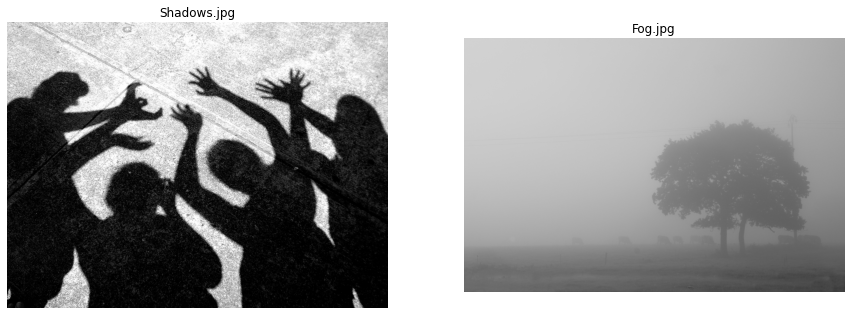

In [57]:
from ex_2 import histogram, negative, contrast 

img1 = cv2.imread('images/shadows.jpg')
img2 = cv2.imread('images/fog.jpg')

display([img1, img2], ['Shadows.jpg', 'Fog.jpg'])

### a. Greyscale Distribution

Two greyscale images are shown, comprising of a 2 dimensional array of valueas ranging from $(0 - 255)$ with higher values indicating darker pixels.  By iterating over each value in the array and summing up the total number of times each value is encountered, a histogram can be formed with 255 bins.  

The distribution of the Fog image, containing mainly low intensity greys will show a distribution weighted around the central point with few, if any very light or very dark points, there will be almos nothing in the 0 and 255 sections of the histogram.

Conversely, the sharp contrast of dark and light parts of the Shadows image will show spikes at the two extremes with very little in the centre section of the plot.

In [58]:
data_img1 = histogram(img1)
data_neg1 = histogram(negative(img1))
data_img2 = histogram(img2)
data_neg2 = histogram(negative(img2))

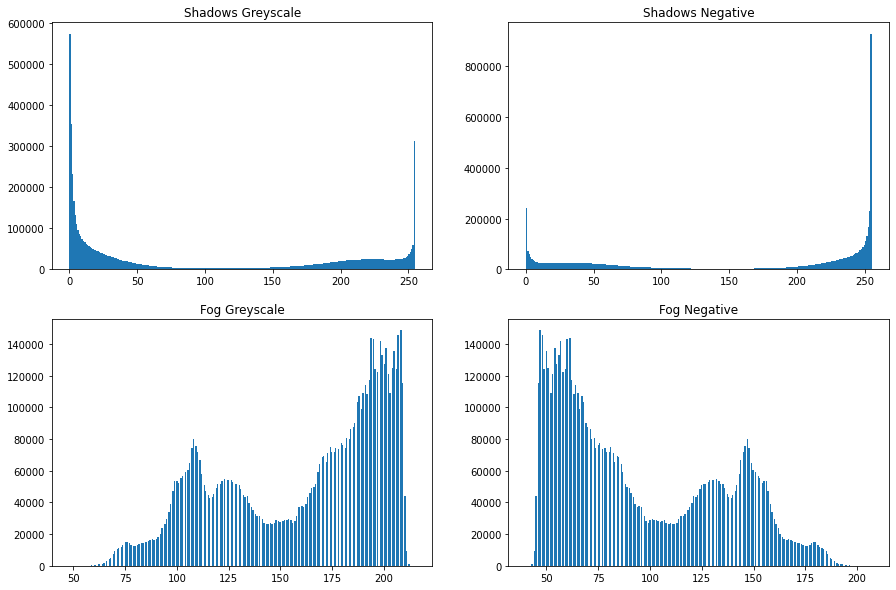

In [59]:
fig = plt.figure(figsize=(15,10))

plt.subplot(2, 2, 1)
plt.hist(data_img1, bins=255)
plt.title('Shadows Greyscale')

plt.subplot(2, 2, 2)
plt.title('Shadows Negative')
plt.hist(data_neg1, bins=255)

plt.subplot(2, 2, 3)
plt.title('Fog Greyscale')
plt.hist(data_img2, bins=255)

plt.subplot(2, 2, 4)
plt.title('Fog Negative')
plt.hist(data_neg2, bins=255)


plt.show()

### b. Negative Pointwise Transform

By applying a negative pointwise function to each pixel, assigning to each pixel the inverse of the pixel value such that $v \gets (255 - v)$ shown below is the effect of inverting each pixel value.  This can also be observed in the histograms above, where the distribution of values is inverted along the centerpoint of the $x$-axis around the point where $x = \frac{255}{2}$.

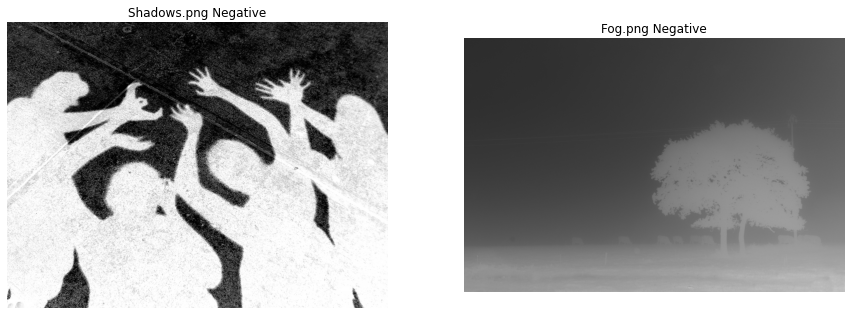

In [77]:
img1_neg = negative(img1)
img2_neg = negative(img2)
display([img1_neg, img2_neg], ['Shadows.png Negative', 'Fog.png Negative'])

### c. Negative Histograms

Note two phenomena within the histograms; firstly the negative shadows image has a spike at 255 double that of the original (some 4000 occurances to less than 2000 in the original), where presumeably a rounding issue is causing the values at the extreme end of the spectrum to be inverted and then rounded to a different bucket.  An attempt at correcting for this was made, by rounding to the nearest integer before inverting, however this did not significantly effect the histogram.  Reducing the number of buckets removed this error.

Secondly, the Fog image has regularly spaced gaps within its histogram, as entire light levels are completely absent this is hypothesised to be the after effect of a compression algorithm or poor original image as a regular pattern of one wide gap followed by three small gaps can be clearly observed. 

### d. Power Law Transform

The contrast of the images can be modified by applying the rule $s \gets r^{n}$ (where $s$ and $r$ are pixel values) can be used to correct the differences between the way that a camera captures images (taking the abolute value of photons entering the reciever) and the way that humans percieve light, where the differences are discrimiated more depending on the intensity of the surrounding area of the image.

A more controllable, non-linear, method was used as an alternative to $s = r^{n}$ in the form of Gamma correction.  The constant $\gamma$ was used to set the amount of constrast required using the formula $s = r^{\frac{1}{\gamma}}$.

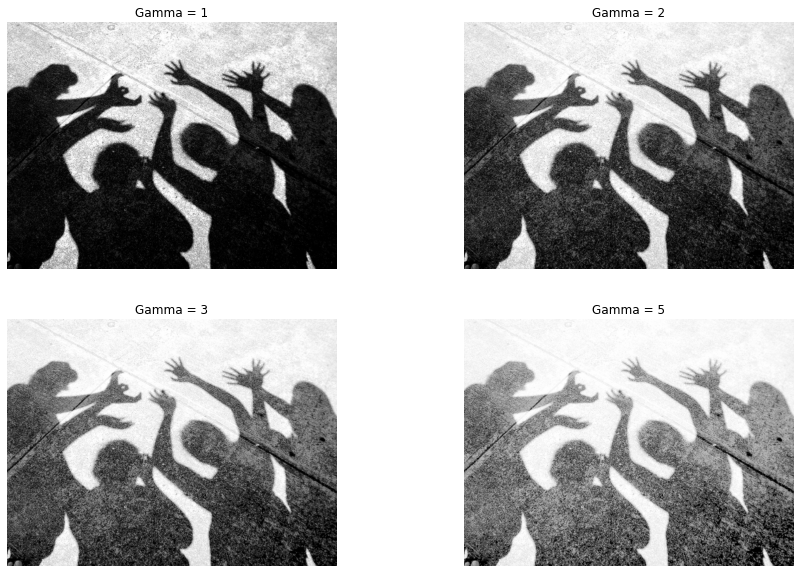

In [82]:
display([contrast(img1,1),
         contrast(img1,2),
         contrast(img1,3),
         contrast(img1,5)],
        ['Gamma = 1',
         'Gamma = 2', 
         'Gamma = 3',
         'Gamma = 5'])

Observe that the use of a high gamma value can help reduce the contrast of the Shadow image revealing the cracks and undulations of the pavement under the peoples' shadows.  Here a gamma of $\gamma = 1$ returns the original image.  As the gamma is increased, the image becomes more faded in very light areas, with pixels converging on either very high or low values.

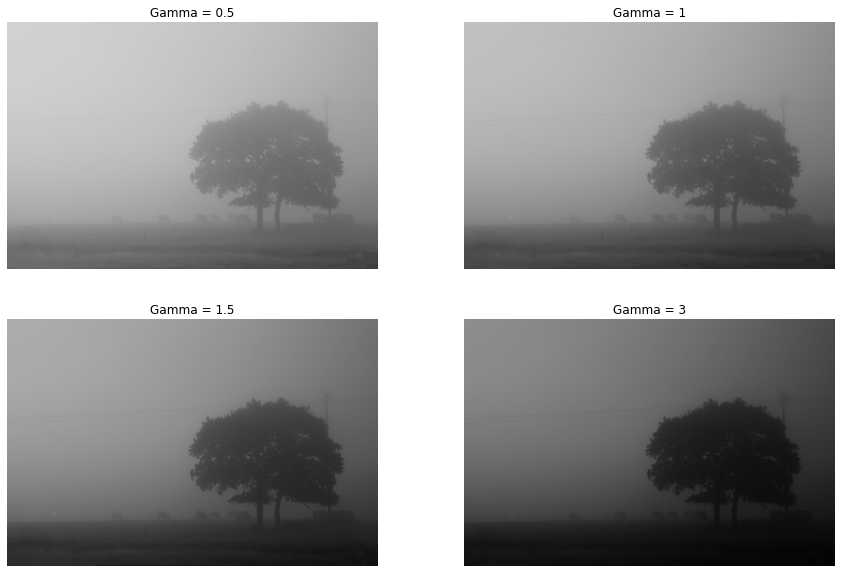

In [83]:
display([contrast(img2,1),
         contrast(img2,0.7),
         contrast(img2,0.5),
         contrast(img2,0.3)],
        ['Gamma = 1',
         'Gamma = 0.7', 
         'Gamma = 0.5',
         'Gamma = 0.3'])

Alternatively reducing the gamma value can allow for perviously 

### References

1. Open Source Computer Vision documentation: https://docs.opencv.org/4.x/de/d25/imgproc_color_conversions.html#color_convert_rgb_hsv
